<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
#imports
from jwst_ta_cent_moments import checkbox, fine_centroid
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
from astropy.io import fits
import os

In [2]:
def open_im(file):
    #import MIRI webbpsf file
    
    hdu = fits.open(file)
    head = hdu[0].header
    data = hdu[0].data
    
    return head, data

In [3]:
def centroid_b(im, input_type='image', ext=0, cbox=5, cwin=5, incoord=(0., 0.), roi=None, bgcorr=-1, flat=None, flatext=0, out=None, thresh=0.05, silent=False):
    
    '''
    Implementation of the JWST GENTALOCATE algorithm. Parameters key:
    
    - infile:       FITS filename
    - input_type:   description of input data: 'image' or 'ramp'. If 'ramp'
                    then make_ta_image functin is run. If 'image' (default)
                    centroiding is performed directly on the data in the
                    input file
    - ext:          extension number of the FITS file containing the science data (default = 0)
    - cbox:         the FULL size of the checkbox, in pixels, for coarse centroiding (default = 5)
    - cwin:         the FULL size of the centroid window, in pixels, for fine centroiding (default = 5)
    - incoord:      (x,y) input coordinates of the source position
    - roi:          size of a region of interest to be used for the centroiding (optional). If not set, full image will be used for coarse                       centroiding. 
                        * setting an ROI also requires input coordinates
                        * the ROI size must be bigger than the cbox parameter
    - bgcorr:       background correction parameter. set to:
                        * negative value for NO background subtraction (default)
                        * 0 < bgcorr < 1 for fractional background subtraction
                        * bgcorr > 1 for constant background subtraction number (this number will be subtracted from the entire image)
    - out:          enter a filename for output of the fit results to a file (default = None)
    - thresh:       the fit threshold, in pixels. default is 0.1 px. consider setting this to a higher number for testing, long-wavelength    
                       data or low SNR data to prevent.
    - silent:       set to True if you want to suppress verbose output
    '''

    # Read in data. Create the TA image if requested
#     if input_type.lower() == 'image':
#         hdu = fits.open(infile)
#         im = hdu[ext].data
#         h = hdu[ext].header
#     elif input_type.lower() == 'ramp':
#         im = make_ta_image(infile, ext=ext, useframes=3, save=False)
#         # Save TA image for code testing
#         h0 = fits.PrimaryHDU(im)
#         hl = fits.HDUList([h0])
#         indir, inf = os.path.split(infile)
#         tafile = os.path.join(indir, 'TA_img_for_'+inf)
#         hl.writeto(tafile, overwrite=True)

    # Do background correction first
    if bgcorr > 0.:
        
        # if a ROI size was provided, the value to be subtracted as background will be calculated using the pixels in the ROI only. Otherwise, use the full array.
        if roi is not None:
            im = bgrsub(im, bgcorr, roi, incoord, silent=silent)
        else:
            im = bgrsub(im, bgcorr, -1, incoord, silent=silent)

    # Apply flat field
    if flat is not None:
        # Read in flat
        with fits.open(flat) as ff:
            flatfield = ff[flatext].data
            
        # Flat must be the same size as the data
        ffshape = flatfield.shape
        dshape = im.shape
        if dshape != ffshape:
            raise RunTimeError(("WARNING: flat field shape ({}) does "
                                "not match data shape ({})!"
                                .format(ffshape,dshape)))
        # Apply flat
        im = apply_flat_field(im, flatfield)
        
    ndim = np.ndim(im)
    #pdb.set_trace()
    
    n = [np.size(im, axis=i) for i in range(ndim)]
    
    # NOTE: in python the x-coord is axis 1, y-coord is axis 0
    xin = incoord[0]
    yin = incoord[1]
    if not silent:
        print('Input coordinates = ({0}, {1})'.format(xin, yin))
    
    # Extract the ROI
    if (roi is not None):
        
        #first check that the ROI is larger than the cbox size
        assert roi > cbox, "ROI size must be larger than the cbox parameter"
        
        # now check that the ROI is a sensible number.
        # if it's bigger than the size of the array, use the
        # full array instead
        if (roi >= n[0])|(roi >= n[1]):
            print('ROI size is bigger than the image; using full image instead')
            roi_im = im
            xoffset = 0
            yoffset = 0
            #xc, yc = checkbox(im, cbox, bgcorr)
        else:
            roi_im = im[np.round(yin-(roi/2.)).astype(int):np.round(yin+(roi/2.)).astype(int),
                        np.round(xin-(roi/2.)).astype(int):np.round(xin+(roi/2.)).astype(int)]
            
            
            #print("ROI size is {0}".format(np.shape(roi_im)))
            xoffset = np.round(xin-(roi/2.)).astype(int)
            yoffset = np.round(yin-(roi/2.)).astype(int)
    else:
        #xc, yc = checkbox(im, cbox, bgcorr)
        roi_im = im
        xoffset = 0
        yoffset = 0
    
    # Perform coarse centroiding. Pay attention to coordinate
    # offsets
    xc, yc = checkbox(roi_im, cbox)
    xc += xoffset
    yc += yoffset
    if not silent:
        print('Coarse centroid found at ({0}, {1})'.format(xc, yc))
    
    # Iterate fine centroiding
    # Take the threshold from the input parameter thresh
    iter_thresh = thresh
    nconv = 0
    while nconv == 0:
        xf, yf= fine_centroid(im, cwin, xc, yc)
        err = np.sqrt((xf-xin)**2 + (yf-yin)**2)
        if not silent:
            print(("Fine centroid found at (x, y) = ({0:.4f}, {1:.4f}). "
               "Rms error = {2:.4f}".format(xf, yf, err)))
        if (abs(xf-xc) <= iter_thresh) & (abs(yf-yc) <= iter_thresh):
            nconv = 1
        xc = xf
        yc = yf
    

    return xf, yf

In [49]:
head, data = open_im('MIRI_psf_model_F1000W_0.fits')

In [50]:
head['FILTER']

'F1000W'

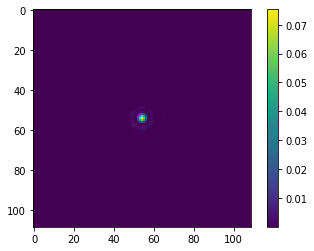

In [51]:
plt.imshow(data)
plt.colorbar()

In [52]:
cent = centroid_b(data)

Input coordinates = (0.0, 0.0)
Coarse centroid found at (54, 54)
Fine centroid found at (x, y) = (54.0040, 53.9883). Rms error = 76.3621


In [72]:
def compute_centroid_diff(data, head):
    
    offset = head['R_OFFSET'] #y offset of psf in pixels
    
    origin = (54,54) #center pixel that psfs offset from
    
    true_cent = np.add(origin, [0, offset])
    
    cent = centroid_b(data,silent=True)
    
    diff = np.subtract(cent,true_cent)*0.11 #diff in arcsec
    
    rms = np.sqrt(np.mean(diff**2))
    
    return rms*1000

In [73]:
f560 = []
f1000 = []
f1500 = []
f2550 = []

for f in os.listdir():
    if f.endswith('.fits'):
        head, data = open_im(f)
        
        filt = head['FILTER']
        
        if filt == 'F560W':
            mas_acc = compute_centroid_diff(data, head)
            f560.append(mas_acc)
            
        elif filt == 'F1000W':
            mas_acc = compute_centroid_diff(data, head)
            f1000.append(mas_acc)
            
        elif filt == 'F1500W':
            mas_acc = compute_centroid_diff(data, head)
            f1500.append(mas_acc)
            
        elif filt == 'F2550W':
            mas_acc = compute_centroid_diff(data, head)
            f2550.append(mas_acc)

In [89]:
np.mean(f560)

14.081403171713944

In [90]:
np.mean(f1000)

14.66258781182637

In [91]:
np.mean(f1500)

11.662985304370933

In [92]:
np.mean(f2550)

9.751846507303288